# Thesis Work

Import statements and defining functions:

In [1]:
from sklearn.feature_extraction import DictVectorizer
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from joblib import Memory
from sklearn.datasets import load_svmlight_file
import neptune
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import Perceptron
from sklearn.utils import resample
import random
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

def linetodict(line):
    return dict(fvs.split(":") for fvs in line[2:].split())

mem = Memory("./mycache")

@mem.cache
def get_data(file_name):
    data = load_svmlight_file(file_name)
    return data[0], data[1]



AddPerceptron to be used with Neptune:

In [2]:
class AddPerceptron_for_neptune:
    
    def __init__(self, **kwargs):
        """Olivia's additive Perceptron implemented through sklearn."""
        self.max_iter = kwargs.get('max_iter', 100) # Store passed max_iter since we rig it to 1
        random.seed(a = kwargs.get('random_state', 42))
        kwargs['max_iter'] = 1
        self.epoch_size = kwargs.pop('epoch_size', 1.0)
        self.clf = Perceptron(**kwargs)
        
    def _shuffler(self, X, y):
        """Resample part of data if epoch_size < 1.0."""
        if self.epoch_size < 1.0:
            return resample(X, y, replace = False, n_samples = int(X.shape[0] * self.epoch_size))
        return X, y
    
    # Change fit to pass more variables so that neptune would work properly
    def fit(self, X, y, X_test=None, y_test=None, run=None, dataset_name=None):
        self.clf.fit(*self._shuffler(X, y))
        
        # Added for neptune.ai
        # Logs the accuracy scores of training and testing of intial run
        train_acc = accuracy_score(y, self.predict(X))
        test_acc = accuracy_score(y_test, self.predict(X_test))
        run[f"{dataset_name}/train/accuracy"].append(train_acc)
        run[f"{dataset_name}/test/accuracy"].append(test_acc)

        for i in range(self.max_iter - 1):
            clfp = Perceptron(max_iter = 1, random_state = random.randint(0,100000000))
            clfp.fit(*self._shuffler(X, y))
            clfpacc = accuracy_score(y_test, clfp.predict(X_test))
            self.clf.coef_ += clfp.coef_
            self.clf.intercept_ += clfp.intercept_
            
            # Added for neptune.ai
            # Logs the accuracy scores of training and testing of each run after initial run
            train_acc = accuracy_score(y, self.predict(X))
            test_acc = accuracy_score(y_test, self.predict(X_test))
            run[f"{dataset_name}/train/accuracy"].append(train_acc)
            run[f"{dataset_name}/test/accuracy"].append(test_acc)
            run[f"{dataset_name}/individual_test/accuracy"].append(clfpacc)
        
  


    def predict(self, X):
        return self.clf.predict(X)

    def score(self, *args, **kwargs):
        return self.clf.score(*args, **kwargs)
    
    

Function to evaluate the add perceptron and plot it in neptune:

In [3]:
def evaluate_addperceptron(train_data, test_data, dataset_name):
    # New neptune run with unique name for each data set
    run = neptune.init_run(
        project="lmrose5522/Perceptron-Training",
        api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI0ODVlOTUzYS02NGNhLTQ5YTQtOWM3Ny1kZGY2OWEzZWQ4YzMifQ==",
    )
    
    # Get the data and separate for training and testing data
    lines = [l.strip() for l in open(train_data)]
    examples = [linetodict(l) for l in lines]
    y_train = [l[0] for l in lines]

    lines = [l.strip() for l in open(test_data)]
    examples_test = [linetodict(l) for l in lines]
    y_test = [l[0] for l in lines]
    
    # Initialize vectorizer and transform the data
    vectorizer = DictVectorizer(sparse=True)
    X_train = vectorizer.fit_transform(examples)
    X_test = vectorizer.transform(examples_test)
    
    # Initialize and train the AddPerceptron model
    clf = AddPerceptron_for_neptune()  
    clf.fit(X_train, y_train, X_test, y_test, run, dataset_name)  

    # Final accuracy on test data
    guesses = clf.predict(X_test)
    accuracy = accuracy_score(y_test, guesses)
    print(f"Final Test Accuracy for {dataset_name}:", accuracy)
    
    # Log accuracy score for neptune to plot
    run[f"{dataset_name}/metrics/final_test_accuracy"] = accuracy
    
    run.stop()

Function to evaluate the add perceptron and plot it in neptune with only one data set file:

In [4]:
def evaluate_addperceptron_2(data, dataset_name):
    # New neptune run with unique name for each data set
    run = neptune.init_run(
        project="lmrose5522/Perceptron-Training",
        api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI0ODVlOTUzYS02NGNhLTQ5YTQtOWM3Ny1kZGY2OWEzZWQ4YzMifQ==",
        name=dataset_name
    )
    
    # Get the data and separate for training and testing data
    lines = [l.strip() for l in open(data)]
    examples = [linetodict(l) for l in lines]
    y = [l[0] for l in lines] 

    vectorizer = DictVectorizer(sparse=True)
    X = vectorizer.fit_transform(examples) 
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Initialize and train the AddPerceptron model
    clf = AddPerceptron()  
    clf.fit(X_train, y_train, X_test, y_test, run, dataset_name)  

    # Final accuracy on test data
    guesses = clf.predict(X_test)
    accuracy = accuracy_score(y_test, guesses)
    print(f"Final Test Accuracy for {dataset_name}:", accuracy)
    
    # Log accuracy score for neptune to plot
    run[f"{dataset_name}/metrics/final_test_accuracy"] = accuracy
    
    run.stop()

Original Add Perceptron implementation:

In [5]:
class AddPerceptron:
    
    def __init__(self, **kwargs):
        """Olivia's additive Perceptron implemented through sklearn."""
        self.max_iter = kwargs.get('max_iter', 100) # Store passed max_iter since we rig it to 1
        random.seed(a = kwargs.get('random_state', 42))
        kwargs['max_iter'] = 1
        self.epoch_size = kwargs.pop('epoch_size', 1.0)
        self.clf = Perceptron(**kwargs)
        
    def _shuffler(self, X, y):
        """Resample part of data if epoch_size < 1.0."""
        if self.epoch_size < 1.0:
            return resample(X, y, replace = False, n_samples = int(X.shape[0] * self.epoch_size))
        return X, y
    
    # Change fit to pass more variables so that neptune would work properly
    def fit(self, X, y, X_test=None, y_test=None, run=None, dataset_name=None):
        self.clf.fit(*self._shuffler(X, y))

        for i in range(self.max_iter - 1):
            clfp = Perceptron(max_iter = 1, random_state = random.randint(0,100000000))
            clfp.fit(*self._shuffler(X, y))
            self.clf.coef_ += clfp.coef_
            self.clf.intercept_ += clfp.intercept_



    def predict(self, X):
        return self.clf.predict(X)

    def score(self, *args, **kwargs):
        return self.clf.score(*args, **kwargs)
    
    

Updated Add Perceptron for plotting in seaborn:

In [6]:
class AddPerceptron:
    
    def __init__(self, **kwargs):
        """Olivia's additive Perceptron implemented through sklearn."""
        self.max_iter = kwargs.get('max_iter', 100) # Store passed max_iter since we rig it to 1
        random.seed(a = kwargs.get('random_state', 42))
        kwargs['max_iter'] = 1
        self.epoch_size = kwargs.pop('epoch_size', 1.0)
        self.clf = Perceptron(**kwargs)
        self.train_accuracies = []  # Store training accuracies for each epoch
        self.test_accuracies = []   # Store test accuracies for each epoch
        
        
    def _shuffler(self, X, y):
        """Resample part of data if epoch_size < 1.0."""
        if self.epoch_size < 1.0:
            return resample(X, y, replace = False, n_samples = int(X.shape[0] * self.epoch_size))
        return X, y
    
    # Change fit to pass more variables so that neptune would work properly
    def fit(self, X, y, X_test=None, y_test=None, run=None, dataset_name=None):
        self.clf.fit(*self._shuffler(X, y))
        
        train_acc = accuracy_score(y, self.predict(X))
        self.train_accuracies.append(train_acc)
        
        if X_test is not None and y_test is not None:
            test_acc = accuracy_score(y_test, self.predict(X_test))
            self.test_accuracies.append(test_acc)

        for i in range(self.max_iter - 1):
            clfp = Perceptron(max_iter=1, random_state=random.randint(0, 100000000))
            clfp.fit(*self._shuffler(X, y))
            self.clf.coef_ += clfp.coef_
            self.clf.intercept_ += clfp.intercept_
            
            # Log the accuracy scores for each epoch
            train_acc = accuracy_score(y, self.predict(X))
            self.train_accuracies.append(train_acc)
            
            if X_test is not None and y_test is not None:
                test_acc = accuracy_score(y_test, self.predict(X_test))
                self.test_accuracies.append(test_acc)



    def predict(self, X):
        return self.clf.predict(X)

    def score(self, *args, **kwargs):
        return self.clf.score(*args, **kwargs)
    
    

AddSVM (for plotting in seaborn):

In [7]:
class AddSVM:
    
    def __init__(self, **kwargs):
        self.max_iter = kwargs.get('max_iter', 100) # Store passed max_iter since we rig it to 1
        random.seed(a = kwargs.get('random_state', 42))
        kwargs['max_iter'] = 1
        self.epoch_size = kwargs.pop('epoch_size', 1.0)
        self.clf = Perceptron(**kwargs)
        self.train_accuracies = []  # Store training accuracies for each epoch
        self.test_accuracies = []   # Store test accuracies for each epoch
        
        
    def _shuffler(self, X, y):
        """Resample part of data if epoch_size < 1.0."""
        if self.epoch_size < 1.0:
            return resample(X, y, replace = False, n_samples = int(X.shape[0] * self.epoch_size))
        return X, y
    
    # Change fit to pass more variables so that neptune would work properly
    def fit(self, X, y, X_test=None, y_test=None, run=None, dataset_name=None):
        self.clf.fit(*self._shuffler(X, y))
        
        train_acc = accuracy_score(y, self.predict(X))
        self.train_accuracies.append(train_acc)
        
        if X_test is not None and y_test is not None:
            test_acc = accuracy_score(y_test, self.predict(X_test))
            self.test_accuracies.append(test_acc)

        for i in range(self.max_iter - 1):
            clfp = svm.LinearSVC(max_iter=1, random_state=random.randint(0, 100000000))
            clfp.fit(*self._shuffler(X, y))
            self.clf.coef_ += clfp.coef_
            self.clf.intercept_ += clfp.intercept_
            
            # Log the accuracy scores for each epoch
            train_acc = accuracy_score(y, self.predict(X))
            self.train_accuracies.append(train_acc)
            
            if X_test is not None and y_test is not None:
                test_acc = accuracy_score(y_test, self.predict(X_test))
                self.test_accuracies.append(test_acc)



    def predict(self, X):
        return self.clf.predict(X)

    def score(self, *args, **kwargs):
        return self.clf.score(*args, **kwargs)
    
    

AddLogRegression (for plotting in seaborn):

In [8]:
class AddLogRegression:
    
    def __init__(self, **kwargs):
        self.max_iter = kwargs.get('max_iter', 100) # Store passed max_iter since we rig it to 1
        random.seed(a = kwargs.get('random_state', 42))
        kwargs['max_iter'] = 1
        self.epoch_size = kwargs.pop('epoch_size', 1.0)
        self.clf = Perceptron(**kwargs)
        self.train_accuracies = []  # Store training accuracies for each epoch
        self.test_accuracies = []   # Store test accuracies for each epoch
        
        
    def _shuffler(self, X, y):
        """Resample part of data if epoch_size < 1.0."""
        if self.epoch_size < 1.0:
            return resample(X, y, replace = False, n_samples = int(X.shape[0] * self.epoch_size))
        return X, y
    
    # Change fit to pass more variables so that neptune would work properly
    def fit(self, X, y, X_test=None, y_test=None, run=None, dataset_name=None):
        self.clf.fit(*self._shuffler(X, y))
        
        train_acc = accuracy_score(y, self.predict(X))
        self.train_accuracies.append(train_acc)
        
        if X_test is not None and y_test is not None:
            test_acc = accuracy_score(y_test, self.predict(X_test))
            self.test_accuracies.append(test_acc)

        for i in range(self.max_iter - 1):
            clfp = SGDClassifier(loss='log_loss',penalty=None,max_iter=1, random_state=random.randint(0, 100000000))
            clfp.fit(*self._shuffler(X, y))
            self.clf.coef_ += clfp.coef_
            self.clf.intercept_ += clfp.intercept_
            
            # Log the accuracy scores for each epoch
            train_acc = accuracy_score(y, self.predict(X))
            self.train_accuracies.append(train_acc)
            
            if X_test is not None and y_test is not None:
                test_acc = accuracy_score(y_test, self.predict(X_test))
                self.test_accuracies.append(test_acc)



    def predict(self, X):
        return self.clf.predict(X)

    def score(self, *args, **kwargs):
        return self.clf.score(*args, **kwargs)
    
    

AddNeuralNetwork:

In [9]:
class AddMLPClassifier:
    
    def __init__(self, **kwargs):
        self.max_iter = kwargs.get('max_iter', 100) # Store passed max_iter since we rig it to 1
        random.seed(a = kwargs.get('random_state', 42))
        kwargs['max_iter'] = 1
        self.epoch_size = kwargs.pop('epoch_size', 1.0)
        self.clf = MLPClassifier(**kwargs)
        
    def _shuffler(self, X, y):
        """Resample part of data if epoch_size < 1.0."""
        if self.epoch_size < 1.0:
            return resample(X, y, replace = False, n_samples = int(X.shape[0] * self.epoch_size))
        return X, y
    
    def fit(self, X, y):
        self.clf.fit(X, y)
        self.N = 2
        for i in range(self.max_iter - 1):
            clfp = MLPClassifier(max_iter = 1, random_state = i, hidden_layer_sizes=(100,50))
            clfp.fit(*self._shuffler(X, y))
            for j in range(len(self.clf.coefs_)):
                self.clf.coefs_[j] += (clfp.coefs_[j] - self.clf.coefs_[j]) / (self.N)
                self.clf.intercepts_[j] += (clfp.intercepts_[j] - self.clf.intercepts_[j]) / (self.N)
                x = 2
            self.N += 1

    def predict(self, X):
        return self.clf.predict(X)

    def score(self, *args, **kwargs):
        return self.clf.score(*args, **kwargs)
    
    
    

AddNueralNetwork for plotting in neptune

In [10]:
class AddMLPClassifier_for_neptune:
    
    def __init__(self, **kwargs):
        self.max_iter = kwargs.get('max_iter', 100) # Store passed max_iter since we rig it to 1
        random.seed(a = kwargs.get('random_state', 42))
        kwargs['max_iter'] = 1
        self.epoch_size = kwargs.pop('epoch_size', 1.0)
        self.clf = MLPClassifier(**kwargs)
        
    def _shuffler(self, X, y):
        """Resample part of data if epoch_size < 1.0."""
        if self.epoch_size < 1.0:
            return resample(X, y, replace = False, n_samples = int(X.shape[0] * self.epoch_size))
        return X, y
    
    def fit(self, X, y, X_test=None, y_test=None, run=None, dataset_name=None):
        self.clf.fit(X, y)
        self.N = 2
        
        # Added for neptune.ai
        # Logs the accuracy scores of training and testing of intial run
        train_acc = accuracy_score(y, self.predict(X))
        test_acc = accuracy_score(y_test, self.predict(X_test))
        run[f"{dataset_name}/train/accuracy"].append(train_acc)
        run[f"{dataset_name}/test/accuracy"].append(test_acc)
        
        for i in range(self.max_iter - 1):
            clfp = MLPClassifier(max_iter = 1, random_state = i, hidden_layer_sizes=(100,50))
            clfp.fit(*self._shuffler(X, y))
            clfpacc = accuracy_score(y_test, clfp.predict(X_test))
            for j in range(len(self.clf.coefs_)):
                self.clf.coefs_[j] += (clfp.coefs_[j] - self.clf.coefs_[j]) / (self.N)
                self.clf.intercepts_[j] += (clfp.intercepts_[j] - self.clf.intercepts_[j]) / (self.N)
                x = 2
            self.N += 1
            
            # Added for neptune.ai
            # Logs the accuracy scores of training and testing of each run after initial run
            train_acc = accuracy_score(y, self.predict(X))
            test_acc = accuracy_score(y_test, self.predict(X_test))
            run[f"{dataset_name}/train/accuracy"].append(train_acc)
            run[f"{dataset_name}/test/accuracy"].append(test_acc)
            run[f"{dataset_name}/individual_test/accuracy"].append(clfpacc)

    def predict(self, X):
        return self.clf.predict(X)

    def score(self, *args, **kwargs):
        return self.clf.score(*args, **kwargs)
    
    
    

Function for plotting neural network in Neptune

In [11]:
def evaluate_addmlp(train_data, test_data, dataset_name):
    # New neptune run with unique name for each data set
    run = neptune.init_run(
        project="lmrose5522/Perceptron-Training",
        api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI0ODVlOTUzYS02NGNhLTQ5YTQtOWM3Ny1kZGY2OWEzZWQ4YzMifQ==",
    )
    
    # Get the data and separate for training and testing data
    lines = [l.strip() for l in open(train_data)]
    examples = [linetodict(l) for l in lines]
    y_train = [l[0] for l in lines]

    lines = [l.strip() for l in open(test_data)]
    examples_test = [linetodict(l) for l in lines]
    y_test = [l[0] for l in lines]
    
    # Initialize vectorizer and transform the data
    vectorizer = DictVectorizer(sparse=True)
    X_train = vectorizer.fit_transform(examples)
    X_test = vectorizer.transform(examples_test)
    
    # Initialize and train the AddPerceptron model
    clf = AddMLPClassifier_for_neptune(hidden_layer_sizes=(100,50))  
    clf.fit(X_train, y_train, X_test, y_test, run, dataset_name)  

    # Final accuracy on test data
    guesses = clf.predict(X_test)
    accuracy = accuracy_score(y_test, guesses)
    print(f"Final Test Accuracy for {dataset_name}:", accuracy)
    
    # Log accuracy score for neptune to plot
    run[f"{dataset_name}/metrics/final_test_accuracy"] = accuracy
    
    run.stop()

Function for plotting neural network in Neptune with only one data set file:

In [12]:
def evaluate_addmlp_2(data, dataset_name):
    # New neptune run with unique name for each data set
    run = neptune.init_run(
        project="lmrose5522/Perceptron-Training",
        api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI0ODVlOTUzYS02NGNhLTQ5YTQtOWM3Ny1kZGY2OWEzZWQ4YzMifQ==",
        name=dataset_name
    )
    
    # Get the data and separate for training and testing data
    lines = [l.strip() for l in open(data)]
    examples = [linetodict(l) for l in lines]
    y = [l[0] for l in lines] 

    vectorizer = DictVectorizer(sparse=True)
    X = vectorizer.fit_transform(examples) 
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Initialize and train the AddPerceptron model
    clf = AddMLPClassifier_for_neptune(hidden_layer_sizes=(100,50))  
    clf.fit(X_train, y_train, X_test, y_test, run, dataset_name)  

    # Final accuracy on test data
    guesses = clf.predict(X_test)
    accuracy = accuracy_score(y_test, guesses)
    print(f"Final Test Accuracy for {dataset_name}:", accuracy)
    
    # Log accuracy score for neptune to plot
    run[f"{dataset_name}/metrics/final_test_accuracy"] = accuracy
    
    run.stop()

Extra code might delete:

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

run = neptune.init_run(
        project="lmrose5522/Perceptron-Training",
        api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI0ODVlOTUzYS02NGNhLTQ5YTQtOWM3Ny1kZGY2OWEzZWQ4YzMifQ==",
        name="news20_svm"
    )

run["model/parameters"] = {"classifier": "LinearSVC"}

lines = [l.strip() for l in open('news20.binary')] 
examples = [linetodict(l) for l in lines]
y = [0 if int(l[:2]) == -1 else int(l[:2]) for l in lines]  

vectorizer = DictVectorizer(sparse = True) # Initialize vectorizer
X = vectorizer.fit_transform(examples)     # Transform dicts to feature vectors
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = svm.LinearSVC()

epochs = 100
for epoch in range(epochs):
    clf.fit(X_train, y_train)
    train_guesses = clf.predict(X)
    train_correct = sum(gu == go for gu, go in zip(train_guesses, y))
    train_acc = train_correct / len(y)

    run[f"train/epoch_{epoch + 1}/accuracy"] = train_acc


run["model/training"] = "completed"

print("Accuracy:", accuracy_score(y_test, clf.predict(X_test)))
run["metrics/accuracy"] = accuracy
print("Accuracy:", accuracy)

run.stop()

In [ ]:
lines = [l.strip() for l in open('news20.binary')]
examples = [linetodict(l) for l in lines]
y = [l[0] for l in lines] 

vectorizer = DictVectorizer(sparse=True)
X = vectorizer.fit_transform(examples) 

# Perform 80-20 split for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = Perceptron(max_iter = 1)
clf.fit(X_train, y_train)

numiter = 500
for i in range(numiter):
    clfp = Perceptron(random_state = i, max_iter = 1)
    clfp.fit(X_train, y_train)
    clfpacc = accuracy_score(y_test, clfp.predict(X_test))
    clf.coef_ += clfp.coef_ 
    clf.intercept_ += clfp.intercept_
    #print(i, "Accuracy (cumul. ensemble, single model):", accuracy_score(y_test, clf.predict(X_test)), clfpacc)
    
### Run a Perceptron and SVM normally until convergence ###
clfP = Perceptron()
clfP.fit(X_train, y_train)
print("Regular Perceptron accuracy:", accuracy_score(y_test, clfP.predict(X_test)))

clfS = svm.LinearSVC()
clfS.fit(X_train, y_train)
print("Regular SVM accuracy:", accuracy_score(y_test, clfS.predict(X_test)))

In [ ]:
def evaluate_addperceptron_2(train_data, test_data, dataset_name):
    # New neptune run with unique name for each data set
    run = neptune.init_run(
        project="lmrose5522/Perceptron-Training",
        api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI0ODVlOTUzYS02NGNhLTQ5YTQtOWM3Ny1kZGY2OWEzZWQ4YzMifQ==",
    )
    
    def load_svmlib_file(filename, featfunc = lambda x: x, classfunc = lambda x: x):
        """Loads SVMLIB format file and modifies classes or feature values.
           Can't use sklearn.datasets.load_svmlight_file since it has no callbacks."""
        lines = [l.strip().split() for l in open(filename)]
        Xs = [{int(fvs.split(":")[0]):featfunc(int(fvs.split(":")[1])) for fvs in line[1:]} for line in lines]
        ys = [classfunc(int(l[0])) for l in lines]
        return Xs, ys

    # In IMDB task, class > 4 is considered positive, <= 4 negative
    trainXs, trainy = load_svmlib_file("train/labeledBow.feat", featfunc = lambda x: 1 if x > 0 else 0, \
                              classfunc = lambda x: 1 if x > 4 else 0)
    vectorizer = DictVectorizer(sparse = True) # Initialize vectorizer

    trainX = vectorizer.fit_transform(trainXs) # Transform dicts to feature vectors
    testXs, testy = load_svmlib_file("test/labeledBow.feat", featfunc = lambda x: 1 if x > 0 else 0,\
                                     classfunc = lambda x: 1 if x > 4 else 0)
    testX = vectorizer.transform(testXs)
    
    # Initialize and train the AddPerceptron model
    clf = AddPerceptron_for_neptune()  
    clf.fit(trainX, trainy, testX, testy, run, dataset_name)  

    clf = Perceptron()                      
    clf.fit(trainX, trainy)                              


    guesses = clf.predict(testX)
    accuracy = accuracy_score(testy, guesses)
    print("Accuracy:", accuracy)
    
    # Log accuracy score for neptune to plot
    run[f"{dataset_name}/metrics/final_test_accuracy"] = accuracy
    
    run.stop()

# Restaurant Dataset

Load the data and organize it by test and train:

In [13]:
lines_train = [l.strip() for l in open("hw3data/restaurant_train.txt")]
examples = [linetodict(l) for l in lines_train]
y_train = [int(l[0]) for l in lines_train]

vectorizer = DictVectorizer(sparse = True) 
X_train = vectorizer.fit_transform(examples)   

lines_test = [l.strip() for l in open("hw3data/restaurant_test.txt")]

X_test = [linetodict(l) for l in lines_test]
y_test = [int(l[0]) for l in lines_test]

Normal SVM:

In [14]:
clfs = svm.LinearSVC() 
clfs.fit(X_train, y_train)                

print("Classification accuracy:", accuracy_score(y_test, clfs.predict(vectorizer.transform(X_test))))

Classification accuracy: 0.902


AddSVM:

In [15]:
clfv = AddSVM() 
clfv.fit(X_train, y_train)                

print("Classification accuracy:", accuracy_score(y_test, clfv.predict(vectorizer.transform(X_test))))

Classification accuracy: 0.91


SVM using SGDClassifier:

In [16]:
clfg = SGDClassifier(loss='hinge', penalty=None) 
clfg.fit(X_train, y_train)                

print("Classification accuracy:", accuracy_score(y_test, clfg.predict(vectorizer.transform(X_test))))

Classification accuracy: 0.896


Normal Logistic Regression:

In [17]:
clfl = SGDClassifier(loss='log_loss', penalty=None) 
clfl.fit(X_train, y_train)                

print("Classification accuracy:", accuracy_score(y_test, clfl.predict(vectorizer.transform(X_test))))

Classification accuracy: 0.908


AddLogRegression:

In [18]:
clfr = AddLogRegression() 
clfr.fit(X_train, y_train)                

print("Classification accuracy:", accuracy_score(y_test, clfr.predict(vectorizer.transform(X_test))))

Classification accuracy: 0.93


Normal Perceptron:

In [19]:
clfp = Perceptron() 
clfp.fit(X_train, y_train)                

print("Classification accuracy:", accuracy_score(y_test, clfp.predict(vectorizer.transform(X_test))))

Classification accuracy: 0.902


Add Perceptron:

In [20]:
clfa = AddPerceptron()  
clfa.fit(X_train, y_train)                

print("Classification accuracy:", accuracy_score(y_test, clfa.predict(vectorizer.transform(X_test))))

Classification accuracy: 0.93


Perceptron using SGDClassifier:

In [21]:
clfd = SGDClassifier(loss='perceptron', penalty=None) 
clfd.fit(X_train, y_train)                

print("Classification accuracy:", accuracy_score(y_test, clfd.predict(vectorizer.transform(X_test))))

Classification accuracy: 0.902


Normal Neural Network:

In [22]:
clf = MLPClassifier(hidden_layer_sizes=(100,50)) 
clf.fit(X_train, y_train)                     

print("Classification accuracy:", accuracy_score(y_test, clf.predict(vectorizer.transform(X_test))))

Classification accuracy: 0.918


Add Neural Network:

In [23]:
clfm = AddMLPClassifier(hidden_layer_sizes=(100,50)) 
clfm.fit(X_train, y_train)   

print("Classification accuracy:", accuracy_score(y_test, clfm.predict(vectorizer.transform(X_test))))

Classification accuracy: 0.32


Plotting the Accuracy Scores for Add Perceptron:

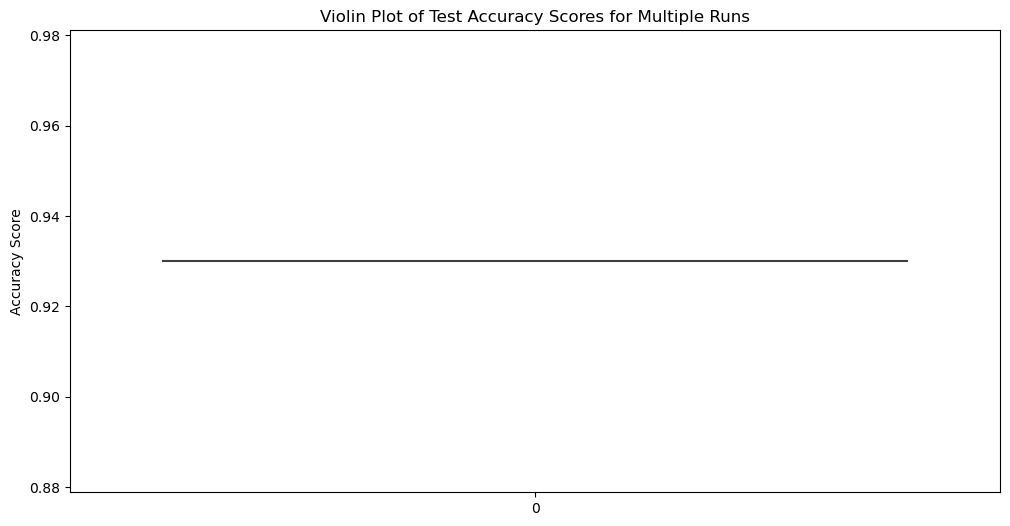

In [24]:
accuracy_scores = []

for _ in range(20):  
    clf = AddPerceptron()  
    clf.fit(X_train, y_train)
    guesses = clf.predict(vectorizer.transform(X_test))
    accuracy = accuracy_score(y_test, guesses)
    accuracy_scores.append(accuracy)
    
# Create a violin plot for training and test accuracies
plt.figure(figsize=(12, 6))
sns.violinplot(data=accuracy_scores)
plt.title('Violin Plot of Test Accuracy Scores for Multiple Runs')
plt.ylabel('Accuracy Score')
plt.show()

Running function to plot the accuracy scores in Neptune for Add Perceptron:

In [22]:
evaluate_addperceptron("hw3data/restaurant_train.txt", "hw3data/restaurant_test.txt", "restaurant")

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/lmrose5522/Perceptron-Training/e/PER-53
Final Test Accuracy for restaurant: 0.93
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 85 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 85 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/lmrose5522/Perceptron-Training/e/PER-53/metadata


Running function to plot the accuracy scores in Neptune for Add Neural Network:

In [23]:
evaluate_addmlp("hw3data/restaurant_train.txt", "hw3data/restaurant_test.txt", "restaurant")

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/lmrose5522/Perceptron-Training/e/PER-54
Final Test Accuracy for restaurant: 0.32
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 91 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 91 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/lmrose5522/Perceptron-Training/e/PER-54/metadata


# Testing Violin Plot 
This is to ensure the line shows the add perceptron is working how we predicted and not that it is just a faulty plot

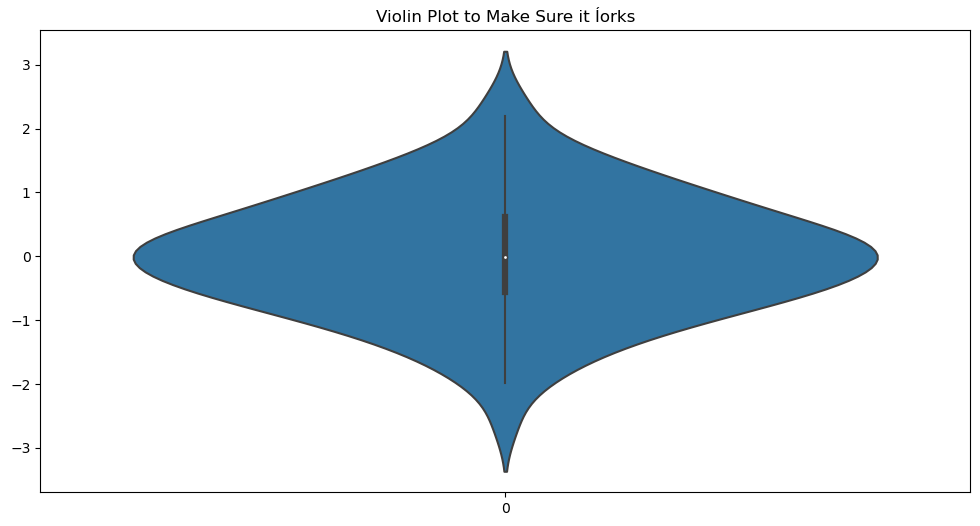

In [24]:
testing = [-0.828995, -0.560181, 0.747294, 0.610370, -0.020902, 1.057122, 0.343618, -1.763040, 0.324084, -0.385082,
          -0.676922, 0.611676, 1.030999, 0.931280, -0.839218, -0.309212, 0.331263, 0.975545, -0.479174, -0.185659,
          -1.106335, -1.196207, 0.812526, 1.356240, -0.072010, 1.003533, 0.361636, -0.645120, 0.361395, 1.538037,
          -0.035826, 1.564644, -2.619745, 0.821902, 0.087047, -0.299007, 0.091761, -1.987569, -0.219672, 0.357113,
          1.477894, -0.518270, -0.808494, -0.501757, 0.915402, 0.328751, -0.529760, 0.513267, 0.097078, 0.968645,
          -0.702053, -0.327662, -0.392108, -1.463515, 0.296120, 0.261055, 0.005113, -0.234587, -1.415371, -0.420645,
          -0.342715, -0.802277, -0.161286, 0.404051, 1.886186, 0.174578, 0.257550, -0.074446, -1.918771, -0.026514,
          0.060230, 2.463242, -0.192361, 0.301547, -0.034712, -1.168678, 1.142823, 0.751933, 0.791032, -0.909387,
          1.402794, -1.401851, 0.586857, 2.190456, -0.990536, -0.566298, 0.099651, -0.503476, -1.550663, 0.068563,
          -1.062304, 0.473592, -0.919424, 1.549934, -0.783253, -0.322062, 0.813517, -1.230864, 0.227460, 1.307143]


plt.figure(figsize=(12, 6))
sns.violinplot(data=testing)
plt.title('Violin Plot to Make Sure it Íorks')
plt.show()

# MNIST Data Set

Load the data and organize it by test and train:

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', cache = True) # This will download a 52Mb file
X = mnist.data.to_numpy()
y = mnist.target.to_numpy()
X = X/255

# Split out 10% of data to test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

/Users/laineyrose/anaconda3/lib/python3.11/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Normal SVM:

In [37]:
clfs = svm.LinearSVC() 
clfs.fit(X_train, y_train)                

print("Classification accuracy:", accuracy_score(y_test, clfs.predict(X_test)))

Classification accuracy: 0.9152857142857143


AddSVM:

In [38]:
clfv = AddSVM() 
clfv.fit(X_train, y_train)                

print("Classification accuracy:", accuracy_score(y_test, clfv.predict(X_test)))

Classification accuracy: 0.9068571428571428


Normal Logistic Regression:

In [39]:
clfl = SGDClassifier(loss='log_loss', penalty=None) 
clfl.fit(X_train, y_train)                

print("Classification accuracy:", accuracy_score(y_test, clfl.predict(X_test)))


Classification accuracy: 0.9117142857142857


AddLogRegression:

In [40]:
clfr = AddLogRegression() 
clfr.fit(X_train, y_train)                

print("Classification accuracy:", accuracy_score(y_test, clfr.predict(X_test)))

Classification accuracy: 0.8995714285714286


Normal Perceptron:

In [42]:
clfp = Perceptron() 
clfp.fit(X_train, y_train)                

print("Classification accuracy:", accuracy_score(y_test, clfp.predict(X_test)))

Classification accuracy: 0.8771428571428571


AddPerceptron:

In [43]:
clfa = AddPerceptron()  
clfa.fit(X_train, y_train)                

print("Classification accuracy:", accuracy_score(y_test, clfa.predict(X_test)))

Classification accuracy: 0.9135714285714286


Normal Nueral Network:

In [44]:
clf = MLPClassifier(hidden_layer_sizes=(100,50)) 
clf.fit(X_train, y_train)                     

print("Classification accuracy:", accuracy_score(y_test, clf.predict(X_test)))

Classification accuracy: 0.9788571428571429


AddNeuralNetwork:

In [48]:
clfm = AddMLPClassifier(hidden_layer_sizes=(100,50)) 
clfm.fit(X_train, y_train)   

print("Classification accuracy:", accuracy_score(y_test, clfm.predict(X_test)))

Classification accuracy: 0.09971428571428571


# A1A Data Set

Load the data and organize it by test and train:

In [57]:
lines_train = [l.strip() for l in open("a1a.txt")]
examples = [linetodict(l) for l in lines_train]
y_train = [l[0] for l in lines_train]

vectorizer = DictVectorizer(sparse = True) 
X_train = vectorizer.fit_transform(examples)   

lines_test = [l.strip() for l in open("a1a_test.txt")]

X_test = [linetodict(l) for l in lines_test]
y_test = [l[0] for l in lines_test]

Normal SVM:

In [58]:
clfs = svm.LinearSVC() 
clfs.fit(X_train, y_train)                

print("Classification accuracy:", accuracy_score(y_test, clfs.predict(vectorizer.transform(X_test))))

Classification accuracy: 0.8385450316578369


Add SVM:

In [59]:
clfv = AddSVM() 
clfv.fit(X_train, y_train)                

print("Classification accuracy:", accuracy_score(y_test, clfv.predict(vectorizer.transform(X_test))))

Classification accuracy: 0.8409355213851919


Normal Logistic Regression:

In [60]:
clfl = SGDClassifier(loss='log_loss', penalty=None) 
clfl.fit(X_train, y_train)                

print("Classification accuracy:", accuracy_score(y_test, clfl.predict(vectorizer.transform(X_test))))

Classification accuracy: 0.8291122884093552


AddLogRegression:

In [61]:
clfr = AddLogRegression() 
clfr.fit(X_train, y_train)                

print("Classification accuracy:", accuracy_score(y_test, clfr.predict(vectorizer.transform(X_test))))

Classification accuracy: 0.842292285825042


Normal Perceptron:

In [62]:
clfp = Perceptron() 
clfp.fit(X_train, y_train)                

print("Classification accuracy:", accuracy_score(y_test, clfp.predict(vectorizer.transform(X_test))))

Classification accuracy: 0.7426024034112935


AddPerceptron:

In [63]:
clfa = AddPerceptron()  
clfa.fit(X_train, y_train)                

print("Classification accuracy:", accuracy_score(y_test, clfa.predict(vectorizer.transform(X_test))))

Classification accuracy: 0.841678511435586


Normal Neural Network:

In [64]:
clf = MLPClassifier(hidden_layer_sizes=(100,50)) 
clf.fit(X_train, y_train)                     

print("Classification accuracy:", accuracy_score(y_test, clf.predict(vectorizer.transform(X_test))))

Classification accuracy: 0.8145109187233492


Add Neural Network:

In [65]:
clfm = AddMLPClassifier(hidden_layer_sizes=(100,50)) 
clfm.fit(X_train, y_train)   

print("Classification accuracy:", accuracy_score(y_test, clfm.predict(vectorizer.transform(X_test))))

Classification accuracy: 0.24053495283628376


Plotting the Accuracy Scores for Add Perceptron:

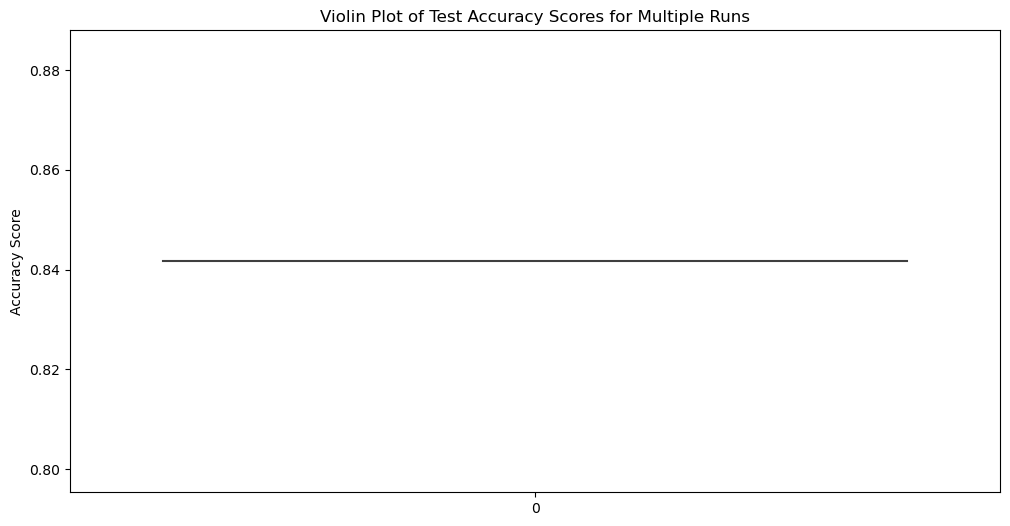

In [64]:
accuracy_scores = []

for _ in range(20):  
    clf = AddPerceptron()  
    clf.fit(X_train, y_train)
    guesses = clf.predict(vectorizer.transform(X_test))
    accuracy = accuracy_score(y_test, guesses)
    accuracy_scores.append(accuracy)
    
# Create a violin plot for training and test accuracies
plt.figure(figsize=(12, 6))
sns.violinplot(data=accuracy_scores)
plt.title('Violin Plot of Test Accuracy Scores for Multiple Runs')
plt.ylabel('Accuracy Score')
plt.show()

Running function to plot the accuracy scores in Neptune for Add Perceptron:

In [35]:
evaluate_addperceptron("a1a.txt", "a1a_test.txt", "a1a")

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/lmrose5522/Perceptron-Training/e/PER-33
Final Test Accuracy for a1a: 0.841678511435586
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 201 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 201 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/lmrose5522/Perceptron-Training/e/PER-33/metadata


Running function to plot the accuracy scores in Neptune for Add Neural Network:

In [65]:
evaluate_addmlp("a1a.txt", "a1a_test.txt", "a1a")

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/lmrose5522/Perceptron-Training/e/PER-52
Final Test Accuracy for a1a: 0.24053495283628376
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 58 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 58 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/lmrose5522/Perceptron-Training/e/PER-52/metadata


# RCV1 Dataset:

Load the data and organize it by test and train:

In [ ]:
lines_train = [l.strip() for l in open("rcv1_train.binary")]
examples = [linetodict(l) for l in lines_train]
y_train = [l[0] for l in lines_train]

vectorizer = DictVectorizer(sparse = True) 
X_train = vectorizer.fit_transform(examples)   

lines_test = [l.strip() for l in open("rcv1_test.binary")]

X_test = [linetodict(l) for l in lines_test]
y_test = [l[0] for l in lines_test]

Normal SVM:

In [ ]:
clfs = svm.LinearSVC() 
clfs.fit(X_train, y_train)                

print("Classification accuracy:", accuracy_score(y_test, clfs.predict(vectorizer.transform(X_test))))

Add SVM:

In [54]:
clfs = svm.LinearSVC() 
clfs.fit(X_train, y_train)                

print("Classification accuracy:", accuracy_score(y_test, clfs.predict(vectorizer.transform(X_test))))

Classification accuracy: 0.8385450316578369


Normal Logistic Regression:

In [55]:
clfl = SGDClassifier(loss='log_loss', penalty=None) 
clfl.fit(X_train, y_train)                

print("Classification accuracy:", accuracy_score(y_test, clfl.predict(vectorizer.transform(X_test))))

Classification accuracy: 0.8315350820519447


AddLogRegression:

In [56]:
clfr = AddLogRegression() 
clfr.fit(X_train, y_train)                

print("Classification accuracy:", accuracy_score(y_test, clfr.predict(vectorizer.transform(X_test))))

Classification accuracy: 0.842292285825042


Normal Perceptron:

In [13]:
clfp = Perceptron() 
clfp.fit(X_train, y_train)                

print("Classification accuracy:", accuracy_score(y_test, clfp.predict(vectorizer.transform(X_test))))

Classification accuracy: 0.5289777516648239


AddPerceptron:

In [35]:
clfa = AddPerceptron()  
clfa.fit(X_train, y_train)                

print("Classification accuracy:", accuracy_score(y_test, clfa.predict(vectorizer.transform(X_test))))

Classification accuracy: 0.5289777516648239


Normal Neural Network:

In [1]:
clf = MLPClassifier(hidden_layer_sizes=(100,50)) 
clf.fit(X_train, y_train)                     

print("Classification accuracy:", accuracy_score(y_test, clf.predict(vectorizer.transform(X_test))))

NameError: name 'MLPClassifier' is not defined

AddNeural Network:

In [ ]:
clfm = AddMLPClassifier(hidden_layer_sizes=(100,50)) 
clfm.fit(X_train, y_train)   

print("Classification accuracy:", accuracy_score(y_test, clfm.predict(vectorizer.transform(X_test))))

Plotting the Accuracy Scores for Add Perceptron:

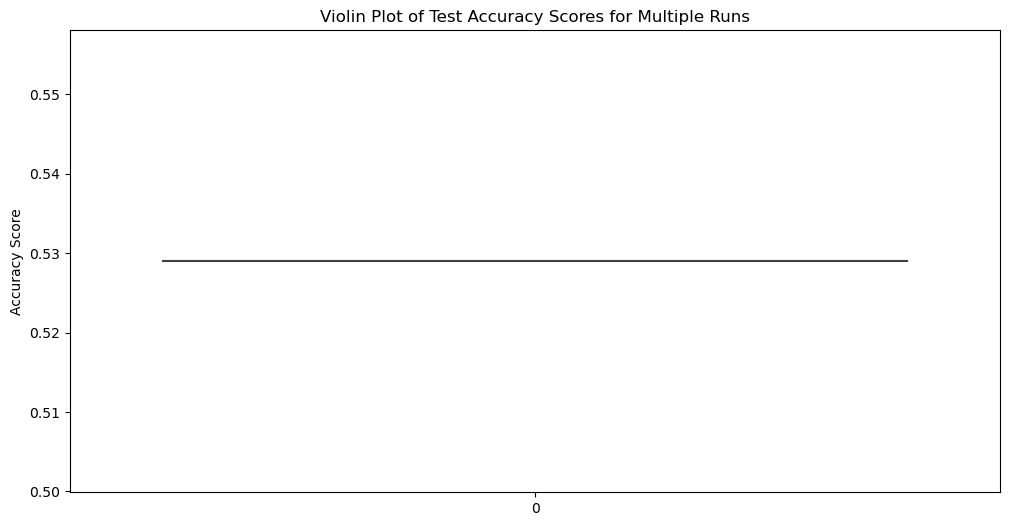

In [14]:
accuracy_scores = []

for _ in range(20):  
    clf = AddPerceptron()  
    clf.fit(X_train, y_train)
    guesses = clf.predict(vectorizer.transform(X_test))
    accuracy = accuracy_score(y_test, guesses)
    accuracy_scores.append(accuracy)
    
# Create a violin plot for training and test accuracies
plt.figure(figsize=(12, 6))
sns.violinplot(data=accuracy_scores)
plt.title('Violin Plot of Test Accuracy Scores for Multiple Runs')
plt.ylabel('Accuracy Score')
plt.show()

Running function to plot the accuracy scores in Neptune for Add Perceptron:

In [ ]:
evaluate_addperceptron("rcv1_train.binary", "rcv1_test.binary", "rcv1")

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/lmrose5522/Perceptron-Training/e/PER-55


Running function to plot the accuracy scores in Neptune for Add Neural Network:

In [1]:
evaluate_addmlp("rcv1_train.binary", "rcv1_test.binary", "rcv1")

NameError: name 'evaluate_addmlp' is not defined

Increasing iterations to 1000 because dataset is larger

In [13]:
class AddPerceptron:
    
    def __init__(self, **kwargs):
        """Olivia's additive Perceptron implemented through sklearn."""
        self.max_iter = kwargs.get('max_iter', 75) # Store passed max_iter since we rig it to 1
        random.seed(a = kwargs.get('random_state', 42))
        kwargs['max_iter'] = 1
        self.epoch_size = kwargs.pop('epoch_size', 1.0)
        self.clf = Perceptron(**kwargs)
        
    def _shuffler(self, X, y):
        """Resample part of data if epoch_size < 1.0."""
        if self.epoch_size < 1.0:
            return resample(X, y, replace = False, n_samples = int(X.shape[0] * self.epoch_size))
        return X, y
    
    def fit(self, X, y):
        self.clf.fit(*self._shuffler(X, y))
        for i in range(self.max_iter - 1):
            clfp = Perceptron(max_iter = 1, random_state = random.randint(0,100000000))
            clfp.fit(*self._shuffler(X, y))
            self.clf.coef_ += clfp.coef_
            self.clf.intercept_ += clfp.intercept_

    def predict(self, X):
        return self.clf.predict(X)

    def score(self, *args, **kwargs):
        return self.clf.score(*args, **kwargs)

# Gisette Data Set

Load the data and organize it by test and train:

In [14]:
lines_train = [l.strip() for l in open("gisette_train")]
examples = [linetodict(l) for l in lines_train]
y_train = [l[0] for l in lines_train]

vectorizer = DictVectorizer(sparse = True) 
X_train = vectorizer.fit_transform(examples)   

lines_test = [l.strip() for l in open("gisette_test")]

X_test = [linetodict(l) for l in lines_test]
y_test = [l[0] for l in lines_test]

Normal SVM:

In [15]:
clfs = svm.LinearSVC() 
clfs.fit(X_train, y_train)                

print("Classification accuracy:", accuracy_score(y_test, clfs.predict(vectorizer.transform(X_test))))

Classification accuracy: 0.982


AddSVM:

In [16]:
clfv = AddSVM() 
clfv.fit(X_train, y_train)                

print("Classification accuracy:", accuracy_score(y_test, clfv.predict(vectorizer.transform(X_test))))

Classification accuracy: 0.958


Normal Logistic Regression:

In [17]:
clfl = SGDClassifier(loss='log_loss', penalty=None) 
clfl.fit(X_train, y_train)                

print("Classification accuracy:", accuracy_score(y_test, clfl.predict(vectorizer.transform(X_test))))


Classification accuracy: 0.979


AddLogRegression:

In [18]:
clfr = AddLogRegression() 
clfr.fit(X_train, y_train)                

print("Classification accuracy:", accuracy_score(y_test, clfr.predict(vectorizer.transform(X_test))))

Classification accuracy: 0.965


Normal Perceptron:

In [19]:
clfp = Perceptron() 
clfp.fit(X_train, y_train)                

print("Classification accuracy:", accuracy_score(y_test, clfp.predict(vectorizer.transform(X_test))))

Classification accuracy: 0.964


AddPerceptron:

In [20]:
clfa = AddPerceptron()  
clfa.fit(X_train, y_train)                

print("Classification accuracy:", accuracy_score(y_test, clfa.predict(vectorizer.transform(X_test))))

Classification accuracy: 0.964


Normal Nueral Network:

In [21]:
clf = MLPClassifier(hidden_layer_sizes=(100,50)) 
clf.fit(X_train, y_train)                     

print("Classification accuracy:", accuracy_score(y_test, clf.predict(vectorizer.transform(X_test))))

Classification accuracy: 0.939


AddNeuralNetwork:

In [ ]:
clfm = AddMLPClassifier(hidden_layer_sizes=(100,50)) 
clfm.fit(X_train, y_train)   

print("Classification accuracy:", accuracy_score(y_test, clfm.predict(vectorizer.transform(X_test))))

Plotting the Accuracy Scores for Add Perceptron:

In [ ]:
accuracy_scores = []

for _ in range(20):  
    clf = AddPerceptron()  
    clf.fit(X_train, y_train)
    guesses = clf.predict(vectorizer.transform(X_test))
    accuracy = accuracy_score(y_test, guesses)
    accuracy_scores.append(accuracy)
    
# Create a violin plot for training and test accuracies
plt.figure(figsize=(12, 6))
sns.violinplot(data=accuracy_scores)
plt.title('Violin Plot of Test Accuracy Scores for Multiple Runs')
plt.ylabel('Accuracy Score')
plt.show()

Running function to plot the accuracy scores in Neptune for Add Perceptron:

In [50]:
evaluate_addperceptron("gisette_train", "gisette_test", "giestte")

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/lmrose5522/Perceptron-Training/e/PER-14
Final Test Accuracy for giestte: 0.966
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 13 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 13 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/lmrose5522/Perceptron-Training/e/PER-14/metadata


Running function to plot the accuracy scores in Neptune for Add Neural Network:

In [ ]:
evaluate_addmlp("gisette_train", "gisette_test", "giestte")

This is the first instance I found where accuracy decreased for AddPerceptron in comparison with the SVM model.

Going back to 100 iterations:

In [22]:
class AddPerceptron:
    
    def __init__(self, **kwargs):
        """Olivia's additive Perceptron implemented through sklearn."""
        self.max_iter = kwargs.get('max_iter', 100) # Store passed max_iter since we rig it to 1
        random.seed(a = kwargs.get('random_state', 42))
        kwargs['max_iter'] = 1
        self.epoch_size = kwargs.pop('epoch_size', 1.0)
        self.clf = Perceptron(**kwargs)
        
    def _shuffler(self, X, y):
        """Resample part of data if epoch_size < 1.0."""
        if self.epoch_size < 1.0:
            return resample(X, y, replace = False, n_samples = int(X.shape[0] * self.epoch_size))
        return X, y
    
    def fit(self, X, y):
        self.clf.fit(*self._shuffler(X, y))
        for i in range(self.max_iter - 1):
            clfp = Perceptron(max_iter = 1, random_state = random.randint(0,100000000))
            clfp.fit(*self._shuffler(X, y))
            self.clf.coef_ += clfp.coef_
            self.clf.intercept_ += clfp.intercept_

    def predict(self, X):
        return self.clf.predict(X)

    def score(self, *args, **kwargs):
        return self.clf.score(*args, **kwargs)

# W7A Dataset:

Load the data and organize it by test and train:

In [23]:
lines_train = [l.strip() for l in open("w7a_train.txt")]
examples = [linetodict(l) for l in lines_train]
y_train = [l[0] for l in lines_train]

vectorizer = DictVectorizer(sparse = True) 
X_train = vectorizer.fit_transform(examples)   

lines_test = [l.strip() for l in open("w7a_test.txt")]

X_test = [linetodict(l) for l in lines_test]
y_test = [l[0] for l in lines_test]

Normal SVM:

In [24]:
clfs = svm.LinearSVC() 
clfs.fit(X_train, y_train)                

print("Classification accuracy:", accuracy_score(y_test, clfs.predict(vectorizer.transform(X_test))))

Classification accuracy: 0.9867901185297522


AddSVM:

In [25]:
clfv = AddSVM() 
clfv.fit(X_train, y_train)                

print("Classification accuracy:", accuracy_score(y_test, clfv.predict(vectorizer.transform(X_test))))

Classification accuracy: 0.9863511194476593


Normal Logistic Regression:

In [26]:
clfl = SGDClassifier(loss='log_loss', penalty=None) 
clfl.fit(X_train, y_train)                

print("Classification accuracy:", accuracy_score(y_test, clfl.predict(vectorizer.transform(X_test))))

Classification accuracy: 0.9833978528953985


AddLogRegression:

In [27]:
clfr = AddLogRegression() 
clfr.fit(X_train, y_train)                

print("Classification accuracy:", accuracy_score(y_test, clfr.predict(vectorizer.transform(X_test))))

Classification accuracy: 0.9840363970148063


Normal Perceptron:

In [28]:
clfp = Perceptron() 
clfp.fit(X_train, y_train)                

print("Classification accuracy:", accuracy_score(y_test, clfp.predict(vectorizer.transform(X_test))))

Classification accuracy: 0.9806840403879156


Add Perceptron:

In [29]:
clfa = AddPerceptron()  
clfa.fit(X_train, y_train)                

print("Classification accuracy:", accuracy_score(y_test, clfa.predict(vectorizer.transform(X_test))))

Classification accuracy: 0.9849942131939179


Normal Neural Network:

In [30]:
clf = MLPClassifier(hidden_layer_sizes=(100,50)) 
clf.fit(X_train, y_train)                     

print("Classification accuracy:", accuracy_score(y_test, clf.predict(vectorizer.transform(X_test))))

Classification accuracy: 0.9875084806640859


AddNeuralNetwork:

In [32]:
clfm = AddMLPClassifier(hidden_layer_sizes=(100,50)) 
clfm.fit(X_train, y_train)   

print("Classification accuracy:", accuracy_score(y_test, clfm.predict(vectorizer.transform(X_test))))

Classification accuracy: 0.9705072434848545


Plotting the Accuracy Scores for Add Perceptron:

In [ ]:
accuracy_scores = []

for _ in range(20):  
    clf = AddPerceptron()  
    clf.fit(X_train, y_train)
    guesses = clf.predict(vectorizer.transform(X_test))
    accuracy = accuracy_score(y_test, guesses)
    accuracy_scores.append(accuracy)
    
# Create a violin plot for training and test accuracies
plt.figure(figsize=(12, 6))
sns.violinplot(data=accuracy_scores)
plt.title('Violin Plot of Test Accuracy Scores for Multiple Runs')
plt.ylabel('Accuracy Score')
plt.show()

Running function to plot the accuracy scores in Neptune for Add Perceptron:

In [51]:
evaluate_addperceptron("w7a_train.txt", "w7a_test.txt", "w7a")

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/lmrose5522/Perceptron-Training/e/PER-15
Final Test Accuracy for w7a: 0.9849942131939179
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 109 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 109 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/lmrose5522/Perceptron-Training/e/PER-15/metadata


Running function to plot the accuracy scores in Neptune for Add Neural Network:

In [ ]:
evaluate_addmlp("w7a_train.txt", "w7a_test.txt", "w7a")

# News20 Dataset:

Load the data and organize it by test and train:

In [33]:
lines = [l.strip() for l in open('news20.binary')] 
examples = [linetodict(l) for l in lines]
y = [0 if int(l[:2]) == -1 else int(l[:2]) for l in lines]  

vectorizer = DictVectorizer(sparse = True)
X = vectorizer.fit_transform(examples)     
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Normal SVM:

In [35]:
clfs = svm.LinearSVC() 
clfs.fit(X_train, y_train)                

print("Classification accuracy:", accuracy_score(y_test, clfs.predict(X_test)))

Classification accuracy: 0.56425


AddSVM:

In [ ]:
clfv = AddSVM() 
clfv.fit(X_train, y_train)                

print("Classification accuracy:", accuracy_score(y_test, clfv.predict(X_test)))

Normal Logistic Regression:

In [ ]:
clfl = SGDClassifier(loss='log_loss', penalty=None) 
clfl.fit(X_train, y_train)                

print("Classification accuracy:", accuracy_score(y_test, clfl.predict(X_test)))

AddLogRegression:

In [ ]:
clfr = AddLogRegression() 
clfr.fit(X_train, y_train)                

print("Classification accuracy:", accuracy_score(y_test, clfr.predict(X_test)))

Normal Perceptron:

In [ ]:
clfp = Perceptron() 
clfp.fit(X_train, y_train)                

print("Classification accuracy:", accuracy_score(y_test, clfp.predict(X_test)))

Add Perceptron:

In [ ]:
clfa = AddPerceptron()  
clfa.fit(X_train, y_train)                

print("Classification accuracy:", accuracy_score(y_test, clfa.predict(X_test)))

Normal Neural Network:

In [ ]:
clf = MLPClassifier(hidden_layer_sizes=(100,50)) 
clf.fit(X_train, y_train)                     

print("Classification accuracy:", accuracy_score(y_test, clf.predict(X_test)))

AddNeuralNetwork:

In [ ]:
clfm = AddMLPClassifier(hidden_layer_sizes=(100,50)) 
clfm.fit(X_train, y_train)   

print("Classification accuracy:", accuracy_score(y_test, clfm.predict(X_test)))

Plotting the Accuracy Scores for Add Perceptron:

In [ ]:
accuracy_scores = []

for _ in range(20):  
    clf = AddPerceptron()  
    clf.fit(X_train, y_train)
    guesses = clf.predict(vectorizer.transform(X_test))
    accuracy = accuracy_score(y_test, guesses)
    accuracy_scores.append(accuracy)
    
# Create a violin plot for training and test accuracies
plt.figure(figsize=(12, 6))
sns.violinplot(data=accuracy_scores)
plt.title('Violin Plot of Test Accuracy Scores for Multiple Runs')
plt.ylabel('Accuracy Score')
plt.show()

Running function to plot the accuracy scores in Neptune for Add Perceptron:

In [1]:
evaluate_addperceptron_2("news20.binary", "news20")

NameError: name 'evaluate_addperceptron_2' is not defined

Running function to plot the accuracy scores in Neptune for Add Neural Network:

In [ ]:
evaluate_addmlp_2("news20.binary", "news20")

# IMDB Dataset

Load the data and organize it by test and train. Also, clean up the data:

In [ ]:
def load_svmlib_file(filename, featfunc = lambda x: x, classfunc = lambda x: x):
    """Loads SVMLIB format file and modifies classes or feature values.
       Can't use sklearn.datasets.load_svmlight_file since it has no callbacks."""
    lines = [l.strip().split() for l in open(filename)]
    Xs = [{int(fvs.split(":")[0]):featfunc(int(fvs.split(":")[1])) for fvs in line[1:]} for line in lines]
    ys = [classfunc(int(l[0])) for l in lines]
    return Xs, ys

# In IMDB task, class > 4 is considered positive, <= 4 negative
trainXs, trainy = load_svmlib_file("train/labeledBow.feat", featfunc = lambda x: 1 if x > 0 else 0, \
                          classfunc = lambda x: 1 if x > 4 else 0)
vectorizer = DictVectorizer(sparse = True) # Initialize vectorizer

trainX = vectorizer.fit_transform(trainXs) # Transform dicts to feature vectors
testXs, testy = load_svmlib_file("test/labeledBow.feat", featfunc = lambda x: 1 if x > 0 else 0,\
                                 classfunc = lambda x: 1 if x > 4 else 0)
testX = vectorizer.transform(testXs)

Normal SVM:

In [ ]:
clfs = svm.LinearSVC() 
clfs.fit(train,X trainy)                

print("Classification accuracy:", accuracy_score(testy, clfs.predict(testX)))

AddSVM:

In [ ]:
clfv = AddSVM() 
clfv.fit(X_train, y_train)                

print("Classification accuracy:", accuracy_score(y_test, clfv.predict(vectorizer.transform(X_test))))

Normal Logistic Regression:

In [ ]:
clfl = SGDClassifier(loss='log_loss', penalty=None) 
clfl.fit(X_train, y_train)                

print("Classification accuracy:", accuracy_score(y_test, clfl.predict(vectorizer.transform(X_test))))

AddLogRegression:

In [ ]:
clfr = AddLogRegression() 
clfr.fit(X_train, y_train)                

print("Classification accuracy:", accuracy_score(y_test, clfr.predict(vectorizer.transform(X_test))))

Normal Perceptron:

In [46]:
clfp = Perceptron() 
clfp.fit(train,X trainy)                

print("Classification accuracy:", accuracy_score(testy, clfp.predict(testX)))

Accuracy: 0.85176


Add Perceptron:

In [ ]:
clfa = AddPerceptron() 
clfa.fit(train,X trainy)                

print("Classification accuracy:", accuracy_score(testy, clfa.predict(testX)))

Normal Neural Network:

In [ ]:
clf = MLPClassifier(hidden_layer_sizes=(100,50)) 
clf.fit(train,X trainy)                

print("Classification accuracy:", accuracy_score(testy, clf.predict(testX)))

AddNeuralNetwork:

In [ ]:
clfm = AddMLPClassifier(hidden_layer_sizes=(100,50)) 
clfm.fit(train,X trainy)                

print("Classification accuracy:", accuracy_score(testy, clfm.predict(testX)))

Plotting the Accuracy Scores for Add Perceptron:

In [ ]:
accuracy_scores = []

for _ in range(20):  
    clf = AddPerceptron()  
    clf.fit(X_train, y_train)
    guesses = clf.predict(vectorizer.transform(X_test))
    accuracy = accuracy_score(y_test, guesses)
    accuracy_scores.append(accuracy)
    
# Create a violin plot for training and test accuracies
plt.figure(figsize=(12, 6))
sns.violinplot(data=accuracy_scores)
plt.title('Violin Plot of Test Accuracy Scores for Multiple Runs')
plt.ylabel('Accuracy Score')
plt.show()

Running function to plot the accuracy scores in Neptune for Add Perceptron:

In [51]:
evaluate_addperceptron_2("train/labeledBow.feat", "train/labeledBow.feat", "imdb")

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/lmrose5522/Perceptron-Training/e/PER-36
Accuracy: 0.85176
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 177 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 177 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/lmrose5522/Perceptron-Training/e/PER-36/metadata


Running function to plot the accuracy scores in Neptune for Add Neural Network:

In [ ]:
evaluate_addmlp_2("train/labeledBow.feat", "train/labeledBow.feat", "imdb")

# Testing Neural Network Averaging Formula

In [59]:
matrix_1 = np.array([
        [71, 95, 75, 2, 30],
        [26, 93, 52, 94, 25],
        [33, 78, 12, 53, 48],
        [49, 45, 21, 7, 90],
        [37, 55, 97, 67, 45]
    ])

matrix_2 = np.array([
        [32, 67, 88, 74, 39],
        [44, 22, 54, 19, 72],
        [50, 63, 29, 47, 92],
        [70, 31, 84, 55, 11],
        [80, 68, 23, 36, 41]
    ])

matrix_3 = np.array([
        [25, 43, 65, 77, 93],
        [91, 84, 61, 58, 64],
        [12, 42, 56, 91, 39],
        [53, 29, 18, 85, 73],
        [47, 35, 22, 19, 88]
    ])

matrix_1 = matrix_1.astype(float)

N = 2


for j in range(len(matrix_1)):
    matrix_1[j] += (matrix_2[j] - matrix_1[j]) / N
N += 1
    
print(matrix_1)   
print(N)
    
for i in range(len(matrix_1)):
    matrix_1[i] += (matrix_3[i] - matrix_1[i]) / N
    

print(matrix_1)

[[51.5 81.  81.5 38.  34.5]
 [35.  57.5 53.  56.5 48.5]
 [41.5 70.5 20.5 50.  70. ]
 [59.5 38.  52.5 31.  50.5]
 [58.5 61.5 60.  51.5 43. ]]
3
[[42.66666667 68.33333333 76.         51.         54.        ]
 [53.66666667 66.33333333 55.66666667 57.         53.66666667]
 [31.66666667 61.         32.33333333 63.66666667 59.66666667]
 [57.33333333 35.         41.         49.         58.        ]
 [54.66666667 52.66666667 47.33333333 40.66666667 58.        ]]
